In [1]:
%load_ext autoreload

import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from numpy.lib.stride_tricks import sliding_window_view
from last_layer_models import LLI, train_last_layer_det, get_post_pred_dens
from gibbs_sampler import gibbs_sampler, get_pred_post_dist
from torch.distributions import MultivariateNormal, Normal

import seaborn as sns

/Users/clarahoffmann/Documents/code/last_layer_inference/last-layer-inf/src/last_layer_inf/gibbs_sampler.py:80: SyntaxWarning: invalid escape sequence '\i'
  The pred. mean and standard deviation are integrated numericall via by \int y *pdf(y) dy


Text(0.5, 1.0, 'Training/Validation split')

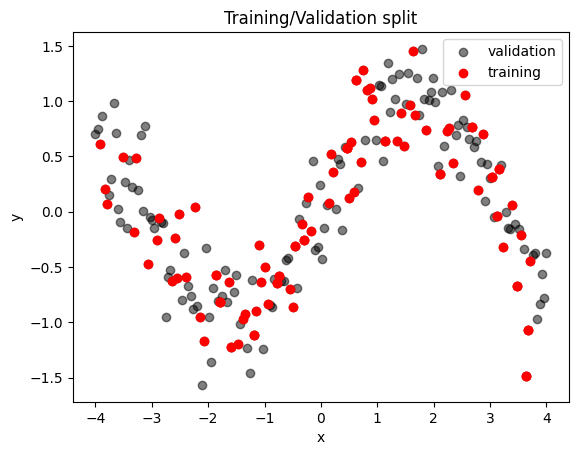

In [2]:
def f(x: float, noise: bool = True, sigma_eps: float = 0.1):
    """Generates a sample y_i from y = sin(x) + varepsilon."""
    y = math.sin(x)
    if noise:
        y += sigma_eps*np.random.randn(1)
    return y

# draw data
sigma_eps = 0.3
xs = np.linspace(-4,4,200)
ys = np.array([f(x = x, noise = True, sigma_eps = sigma_eps) for x in xs])

# sample train indices
train_idx = np.random.randint(0, len(xs), 100)

xs_train = torch.tensor(xs[train_idx]).unsqueeze(-1).float()
ys_train = torch.tensor(ys[train_idx]).float()

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

In [4]:
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100

100%|██████████| 100/100 [00:00<00:00, 176.20it/s]


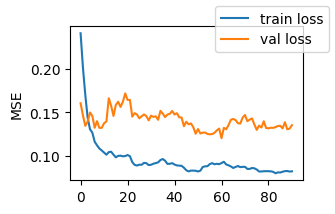

In [5]:
lli_net = LLI(model_dims)
sigma_0 = 0.3

lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [6]:
lli_net.eval()
Psi = lli_net.get_ll_embedd(xs_train)

In [16]:
a_tau = 0
b_tau = .1
a_sigma = 0
b_sigma = .1
num_iter = 1000
warm_up = 600
w_sample, tau_sq_sample, sigma_sq_sample = gibbs_sampler(Psi, ys_train, a_tau, b_tau, a_sigma, b_sigma, num_iter, warm_up)

100%|██████████| 1000/1000 [00:00<00:00, 3268.19it/s]


In [17]:
ys_grid = torch.arange(-5,5, .01)

xs_pred_np = np.linspace(-10,10,200)
xs_pred = torch.tensor(xs_pred_np).unsqueeze(-1).float()

Psi_pred = lli_net.get_ll_embedd(xs_pred)

preds = {'mean': [],
         'var': []}
for i in range(Psi_pred.shape[0]):
    _, y_mean, y_var = get_pred_post_dist(Psi_pred[i], w_sample, sigma_sq_sample, ys_grid)
    preds['mean'].append(y_mean)
    preds['var'].append(y_var)

[]

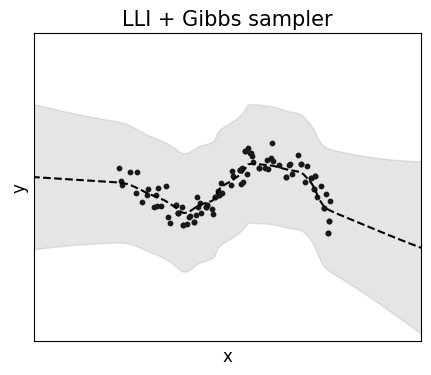

In [18]:
fig, axs = plt.subplots(1,1, figsize = (5, 4))

axs.scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
axs.plot(xs_pred_np.squeeze(), np.array(preds['mean']), c='black', linestyle='dashed', label='posterior mean')
axs.fill_between(xs_pred_np.squeeze(), np.array(preds['mean']) - 2* np.array(preds['var']),  np.array(preds['mean']) + 2*np.array(preds['var']), color = 'grey', alpha = 0.2)

axs.set_xlabel('x', size = 12)
axs.set_ylabel('y', size = 12)

axs.set_title('LLI + Gibbs sampler', size = 15)
axs.set_xlim(-7,7)
axs.set_ylim(-5, 5)
axs.set_yticks([], [])
axs.set_xticks([], [])